In [ ]:
import pandas as pd

In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset")

file_path = os.path.join(path, "Sleep_health_and_lifestyle_dataset.csv")
df = pd.read_csv(file_path)

Using Colab cache for faster access to the 'sleep-health-and-lifestyle-dataset' dataset.


## Checagem do Dataset

In [ ]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
df['Blood Pressure'].value_counts()

,count
Blood Pressure,
130/85,99
140/95,65
125/80,65
120/80,45
115/75,32
135/90,27
140/90,4
125/82,4
128/85,3


In [ ]:
print(f"{df.shape} \n")
print(f"{df.dtypes} \n")
print(f"{df.isnull().sum()} \n")

(374, 13) 

Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object 

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64 



In [ ]:
# Validação do formato do dataset
# Blood Pressure está uniformemente no formato 'int/int'

import re

pattern = r'^\d+/\d+$'

invalid_bp = df[~df['Blood Pressure'].astype(str).str.match(pattern)]

print(f"Valores fora do padrão esperado: {len(invalid_bp)}")
invalid_bp['Blood Pressure'].value_counts().head(10)


Valores fora do padrão esperado: 0


,count
Blood Pressure,


Após validação do formato da variável Blood Pressure via regex, verificou-se que todos os registros seguem o padrão numérico ‘sistólica/diastólica’, permitindo o parsing direto sem perda de informação.

## Dataset Base para previsão





In [ ]:
def base_dataset(df):

    df_base = df.copy()

    # Drop ID
    df_base = df_base.drop(columns=["Person ID"])

    # Sleep Disorder: ausência reportada
    df_base["Sleep Disorder"] = df_base["Sleep Disorder"].fillna("No Disorder")

    # Separar pressão sistólica e diastólica
    df_base[["Systolic", "Diastolic"]] = (
        df_base["Blood Pressure"]
        .str.split("/", expand=True)
        .astype(int)
    )

    def bp_category(row):
        sys = row["Systolic"]
        dia = row["Diastolic"]

        if sys >= 180 or dia >= 110:
            return "Hypertension_Stage3"

        elif (160 <= sys < 180) or (100 <= dia < 110):
            return "Hypertension_Stage2"

        elif (140 <= sys < 160) or (90 <= dia < 100):
            return "Hypertension_Stage1"

        elif (130 <= sys < 140) or (85 <= dia < 90):
            return "Elevated"

        else:
            return "Normal"

    df_base["BP_Category"] = df_base.apply(bp_category, axis=1)

    # Target binário
    df_base["HighRisk"] = df_base["BP_Category"].isin(
        [
            "Hypertension_Stage1",
            "Hypertension_Stage2",
            "Hypertension_Stage3"
        ]
    ).astype(int)

    # Remover colunas auxiliares
    df_base = df_base.drop(columns=["Blood Pressure", "Systolic", "Diastolic"])

    return df_base


In [ ]:
df_clean = base_dataset(df)
df_clean["BP_Category"].value_counts()

,count
BP_Category,
Normal,163
Elevated,111
Hypertension_Stage1,100


## Análise de classes do Dataset

In [ ]:
# Análise de balanceamento

df_clean["HighRisk"].value_counts(normalize=True)

,proportion
HighRisk,
0,0.73262
1,0.26738


In [ ]:
df_clean["BMI Category"].value_counts()


,count
BMI Category,
Normal,195
Overweight,148
Normal Weight,21
Obese,10


As classes "Normal" e "Normal Weight" representam o mesmo estado nutricional. Portanto as categorias devem ser unificadas para evitar que os modelos aprendam uma divisão artificial entre indivíduos

In [ ]:
# Unificação semântica das categorias de IMC
df_clean["BMI Category"] = df_clean["BMI Category"].replace(
    {"Normal": "Normal Weight"}
)
df_clean["BMI Category"].value_counts()

,count
BMI Category,
Normal Weight,216
Overweight,148
Obese,10


## Dataset Features Adicionais

In [ ]:
def features_dataset(df_clean):

    df_features = df_clean.copy()

    # Eficiência do sono (duração × qualidade)
    df_features["Sleep_Efficiency"] = (
        df_features["Sleep Duration"] * df_features["Quality of Sleep"]
    )

    # Índice de estresse cardíaco
    df_features["Cardiac_Stress_Index"] = (
        df_features["Stress Level"] * df_features["Heart Rate"]
    )

    return df_features

In [ ]:
df_features = features_dataset(df_clean)
df_features[["Sleep_Efficiency", "Cardiac_Stress_Index"]].describe()

,Sleep_Efficiency,Cardiac_Stress_Index
count,374.000000,374.000000
mean,52.994652,382.748663
std,13.932198,141.466528
min,23.200000,195.000000
25%,37.950000,260.000000
50%,54.600000,350.000000
75%,61.600000,504.000000
max,76.500000,680.000000


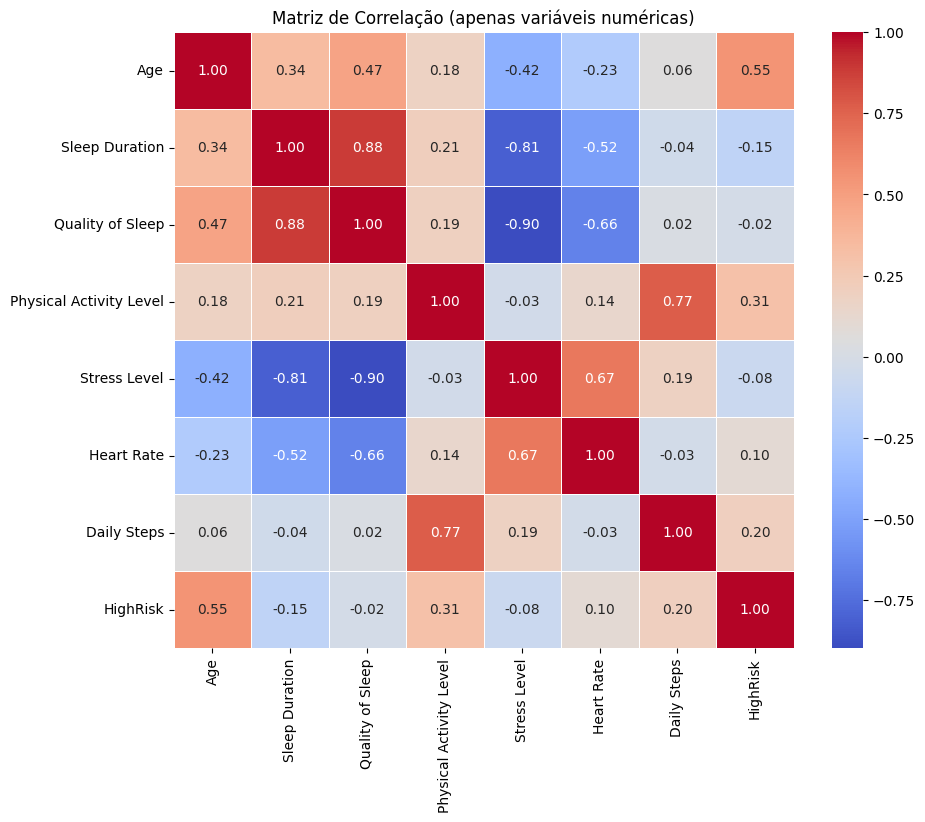

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# apenas colunas numéricas
num_df = df_clean.select_dtypes(include=["int64", "float64"])

corr_matrix_num = num_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_num, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação (apenas variáveis numéricas)")
plt.show()


In [20]:
# Proporção de HighRisk por categoria
cat_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != "BP_Category"]

for col in cat_cols:
    print(f"\n--- {col} ---")
    summary = df_clean.groupby(col)["HighRisk"].agg(["mean", "count"]).sort_values("mean", ascending=False)
    summary = summary.rename(columns={"mean": "P(HighRisk=1)", "count": "n"})
    display(summary)



--- Gender ---


,P(HighRisk=1),n
Gender,,
Female,0.497297,185
Male,0.042328,189



--- Occupation ---


,P(HighRisk=1),n
Occupation,,
Sales Representative,1.000000,2
Nurse,0.890411,73
Teacher,0.700000,40
Software Engineer,0.250000,4
Doctor,0.056338,71
Engineer,0.000000,63
Accountant,0.000000,37
Lawyer,0.000000,47
Manager,0.000000,1



--- BMI Category ---


,P(HighRisk=1),n
BMI Category,,
Obese,0.800000,10
Overweight,0.621622,148
Normal Weight,0.000000,216



--- Sleep Disorder ---


,P(HighRisk=1),n
Sleep Disorder,,
Sleep Apnea,0.807692,78
Insomnia,0.389610,77
No Disorder,0.031963,219


In [21]:
# Idade por gênero
df_clean.groupby("Gender")["Age"].describe()


,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,185.0,47.405405,8.093407,29.0,39.0,50.0,53.0,59.0
Male,189.0,37.074074,5.662006,27.0,32.0,38.0,43.0,49.0


In [22]:
# Distribuição de BMI por gênero (contagem)
pd.crosstab(df_clean["Gender"], df_clean["BMI Category"], normalize="index")


BMI Category,Normal Weight,Obese,Overweight
Gender,,,
Female,0.421622,0.005405,0.572973
Male,0.730159,0.047619,0.222222


In [23]:
# Taxa de HighRisk por gênero e BMI (interação)
pd.pivot_table(
    df_clean,
    values="HighRisk",
    index="Gender",
    columns="BMI Category",
    aggfunc="mean"
)


BMI Category,Normal Weight,Obese,Overweight
Gender,,,
Female,0.0,0.000000,0.867925
Male,0.0,0.888889,0.000000


Observa-se que o risco cardiovascular no dataset está fortemente associado à categoria de IMC, com separação quase determinística quando combinada ao gênero. Isso sugere um viés estrutural na base de dados, possivelmente decorrente de regras de geração ou seleção dos registros, o que limita a generalização dos modelos para cenários reais.

# Salvar no Drive

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

nome_da_pasta = "Ps Ligia Time 16"
caminho_base = "/content/drive/MyDrive/"
caminho_completo = os.path.join(caminho_base, nome_da_pasta)

if not os.path.exists(caminho_completo):
    os.makedirs(caminho_completo)
    print(f"Pasta '{nome_da_pasta}' criada com sucesso!")
else:
    print(f"A pasta '{nome_da_pasta}' já existe.")

# CSV base
caminho_arquivo_base = os.path.join(caminho_completo, "risco_cardiovascular_base.csv")
df_clean.to_csv(caminho_arquivo_base, index=False)

# CSV features adicionais
caminho_arquivo_base = os.path.join(caminho_completo, "risco_cardiovascular_features.csv")
df_features.to_csv(caminho_arquivo_base, index=False)

print(f"Dataset salvo em: {caminho_arquivo_base}")

Mounted at /content/drive
A pasta 'Ps Ligia Time 16' já existe.
Dataset salvo em: /content/drive/MyDrive/Ps Ligia Time 16/risco_cardiovascular_features.csv
